### 本文结合了Stanford的coursera NLP 公开课和nltk的工具库，阐述了语言（英语和中文）语法解析的统计概率方法。

一. 一些工具方法。

In [63]:
#-*- encoding:utf-8 -*-
import nltk
from nltk.treeprettyprinter import TreePrettyPrinter
import matplotlib.pyplot as plt
import matplotlib
import collections
import operator as op
import functools as ft
import numpy as np
import sys
import os
import time

# 计时器，可以通过装饰器给任何函数加入计时功能，但是不能用于递归函数！因为每个子函数调用都会打印时间信息。
def timeit(func):
    def shrink(s, max_len=100):
        if len(s) <= max_len:
            return s
        return s[:max_len-4] + '...' + s[-1:]
    
    def wrapper(*args, **kw):
        print ('call %s(args=%s, kw=%s):' % (func.__name__, shrink(str(args)), shrink(str(kw))))
        t0 = time.clock()
        res = func(*args, **kw)
        print ('consumed %.3f s' % (time.clock() - t0))
        return res
    return wrapper

@timeit
def add(n):
    return sum(range(n))

add(100000000)

call add(args=(100000000,), kw={}):
consumed 2.529 s


4999999950000000

+ 将nltk画出的语法树内嵌到notebook中。这里我们完善了nltk.Tree的pretty_print方法，使其（1）可以很好的支持中文等全角字符的现实，（2）输出内容显示为图片，这样可以避免浏览器对长行的自动折叠，使显示完整又方便保存。

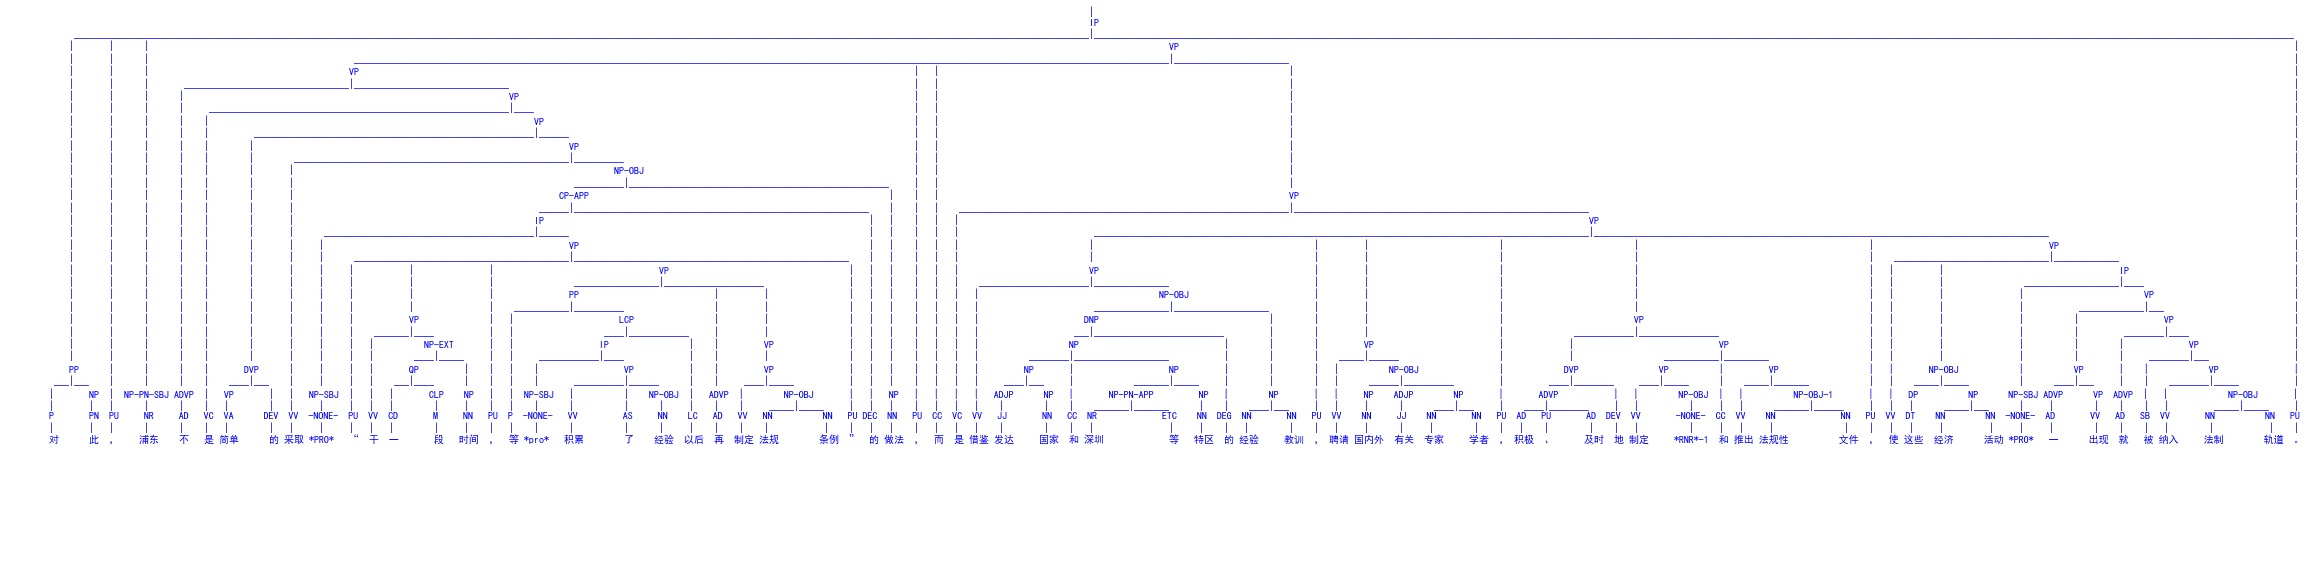

In [56]:
%matplotlib inline
'''
    需要先安装下面两个包：
    brew install ghostscript
    brew install imagemagick
'''
def is_fullwidth(c):
    if not (c < '\u0000' or c > '\u1fff'): #全角
        #print ('半角: ' + c)
        return False
    return True

#print (is_zh_cn('a'))

def draw_tree(tree_str, isascii=False):

    # pretty_print
    #print ('pretty_print:')
    tree = nltk.Tree.fromstring(tree_str)
    leaves = tree.leaves()
    tree_str = TreePrettyPrinter(tree, sentence=None, highlight=()).text(nodedist=1, unicodelines=False, html=False, ansi=False,
             nodecolor='blue', leafcolor='red', funccolor='green',
             abbreviate=None, maxwidth=160000)
    #print (tree_str)
    
    #if not isascii:
    # adjusted leaves
    #print ('adjusted leaves:')
    ratio = 0.5
    delta = 0
    for i, pos in enumerate(tree.treepositions('leaves')):
        word = tree[pos]
        len_word = sum(map(lambda c: 1 if is_fullwidth(c) else ratio, word))
        n_A = int((len_word - delta) / ratio)
        if abs(ratio * n_A - len_word + delta) > abs(ratio * (n_A + 1) - len_word + delta):
            n_A += 1
        tree[pos] = chr(i + ord('A')) * n_A
        delta = ratio * n_A - len_word + delta
    
    tree_str = TreePrettyPrinter(tree, sentence=None, highlight=()).text(nodedist=1, unicodelines=False, html=False, ansi=False,
             nodecolor='blue', leafcolor='red', funccolor='green',
             abbreviate=None, maxwidth=160000)
    
    #print ('substituted leaves:')
    #print (tree_str)
    #print (tree_str.replace(r' ', u'*'))
    
    tree_str = tree_str.split('\n')
    #print (tree_str[-1])
    #print (len(tree_str))
    tree_str = list(filter(lambda xs: len(xs) > 0 and len(xs) > xs.count(' '), tree_str))
    last_line = tree_str[-1]
    #print (last_line)
    new_last_line = [] 
    i = 0
    while i < len(last_line):
        c = last_line[i]
        if c != ' ':
            which_leave = ord(c) - ord('A')
            new_last_line.append(leaves[which_leave])
            while i < len(last_line) and last_line[i] != ' ':
                i += 1
        else:
            new_last_line.append(c)
            i += 1
    
    #print (''.join(new_last_line))
    tree_str[-1] = ''.join(new_last_line)
    tree_str = '\n'.join(tree_str)
    
    #print (tree_str)
    
    # render to pic
    f, ax = plt.subplots()
    #plt.text(0.05, 0.45, u"Microsoft \n YaHei微软雅黑", fontproperties='Microsoft YaHei') 
    #font = matplotlib.font_manager.FontProperties(fname='/Library/Fonts/Microsoft/SimHei.ttf')
    ax.text(0.05, 0.45, tree_str, fontproperties='SimHei', size=20, color='blue')
    ax.set_axis_off()
    plt.show()
    #print ('hello')

# test          
tree_str = u'''
( (IP (PP (P 对) 
	  (NP (PN 此))) 
      (PU ，) 
      (NP-PN-SBJ (NR 浦东)) 
      (VP (VP (ADVP (AD 不)) 
	      (VP (VC 是) 
		  (VP (DVP (VP (VA 简单)) 
			   (DEV 的)) 
		      (VP (VV 采取) 
			  (NP-OBJ (CP-APP (IP (NP-SBJ (-NONE- *PRO*)) 
					      (VP (PU “) 
						  (VP (VV 干) 
						      (NP-EXT (QP (CD 一) 
								  (CLP (M 段))) 
							      (NP (NN 时间)))) 
						  (PU ，) 
						  (VP (PP (P 等) 
							  (LCP (IP (NP-SBJ (-NONE- *pro*)) 
								   (VP (VV 积累) 
								       (AS 了) 
								       (NP-OBJ (NN 经验)))) 
							       (LC 以后))) 
						      (ADVP (AD 再)) 
						      (VP (VP (VV 制定) 
							      (NP-OBJ (NN 法规) 
								      (NN 条例))))) 
						  (PU ”))) 
					  (DEC 的)) 
				  (NP (NN 做法))))))) 
	  (PU ，) 
	  (CC 而) 
	  (VP (VC 是) 
	      (VP (VP (VV 借鉴) 
		      (NP-OBJ (DNP (NP (NP (ADJP (JJ 发达)) 
					   (NP (NN 国家))) 
				       (CC 和) 
				       (NP (NP-PN-APP (NR 深圳) 
						      (ETC 等)) 
					   (NP (NN 特区)))) 
				   (DEG 的)) 
			      (NP (NN 经验) 
				  (NN 教训)))) 
		  (PU ，) 
		  (VP (VV 聘请) 
		      (NP-OBJ (NP (NN 国内外)) 
			      (ADJP (JJ 有关)) 
			      (NP (NN 专家) 
				  (NN 学者)))) 
		  (PU ，) 
		  (VP (DVP (ADVP (AD 积极) 
				 (PU 、) 
				 (AD 及时)) 
			   (DEV 地)) 
		      (VP (VP (VV 制定) 
			      (NP-OBJ (-NONE- *RNR*-1))) 
			  (CC 和) 
			  (VP (VV 推出) 
			      (NP-OBJ-1 (NN 法规性) 
					(NN 文件))))) 
		  (PU ，) 
		  (VP (VV 使) 
		      (NP-OBJ (DP (DT 这些)) 
			      (NP (NN 经济) 
				  (NN 活动))) 
		      (IP (NP-SBJ (-NONE- *PRO*)) 
			  (VP (VP (ADVP (AD 一)) 
				  (VP (VV 出现))) 
			      (VP (ADVP (AD 就)) 
				  (VP (SB 被) 
				      (VP (VV 纳入) 
					  (NP-OBJ (NN 法制) 
						  (NN 轨道))))))))))) 
      (PU 。)) ) 
'''
tree = nltk.Tree.fromstring(tree_str)
draw_tree(str(tree))

#tree.chomsky_normal_form(horzMarkov=0, vertMarkov=1)
#draw_tree(str(tree))

+ 演示一种语法歧义（介词短语PP到底是该修饰其之前的动词短语VP还是名词N）

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))


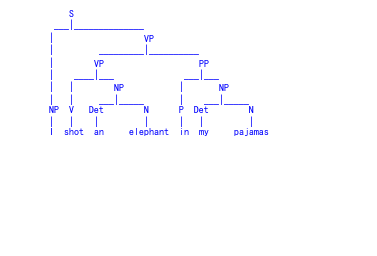

(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


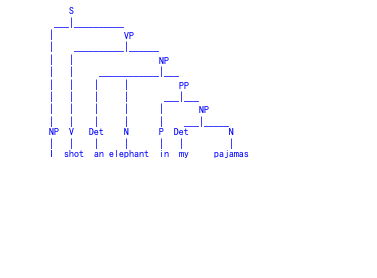

In [3]:
groucho_grammar = nltk.CFG.fromstring("""
    S -> NP VP
    PP -> P NP
    NP -> Det N | Det N PP | 'I'
    VP -> V NP | VP PP
    Det -> 'an' | 'my'
    N -> 'elephant' | 'pajamas'
    V -> 'shot'
    P -> 'in'
    """)
sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
parser = nltk.ChartParser(groucho_grammar)
for tree in parser.parse(sent):
    print(tree)
    draw_tree(str(tree), isascii=True)

+ 为了解决上面的歧义问题，我们引入了概率上下文无关语法（probabilistic context free grammar, PCFG）。为将文件中的字符串语法树转化为内存对象，我们继承nltk.Tree，定义了自己的新Tree类，其中扩展了自己的方法。

    关于nltk.Tree，要注意几点：
        1. preterminal的child是其自己，而不是terminal；
        2. 其内部自带的二叉树转化工具是in-place的，有副作用；
        3. 缺少一些预处理的方法，比如对功能tag的脱离操作等，我们在继承的类中加以丰富；
        4. 自带的draw和pretty_print等调试方法不能很好的支持中文，建议用上面的draw_tree代替；

In [4]:
class Tree(nltk.Tree):
    def __init(self, label, children=None):
        super.__init__(label, children)
        
    def is_preterminal(self):
        """
        Returns true level of non-terminals which are directly above
        single words (leaves).
        """
        return len(self) == 1 and not isinstance(self[0], Tree)

    def is_phrasal(self):
        return not self.is_preterminal()

    def _append_yield(self, leaf_labels):
        if self.is_preterminal():
            leaf_labels.append(self[0])
            return
        for child in self:
            child._append_yield(leaf_labels)

    def get_yield(self):
        """
        Returns a list of words at the leaves of this tree gotten by
        traversing from left to right.
        """
        leaf_labels = []
        self._append_yield(leaf_labels)
        return leaf_labels

    def _append_preterminal_yield(self, preterm_yield):
        if self.is_preterminal():
            preterm_yield.append(self.label())
            return
        for child in self:
            child._append_preterminal_yield(preterm_yield)

    def get_preterminal_yield(self):
        """
        Returns a list of the preterminals gotten by traversing from left
        to right.  This is effectively an POS tagging for the words that
        tree represents.
        """
        preterm_yield = []
        self._append_preterminal_yield(preterm_yield)
        return preterm_yield

    def _set_words_helper(self, words, word_num):
        if self.is_preterminal():
            self[0] = words[word_num]
            return word_num + 1
        else:
            for child in self:
                word_num = child._set_words_helper(words, word_num)
            return word_num

    def set_words(self, words):
        """
        Set the words at the leaves of a tree to the words from the list.
        """
        self._set_words_helper(words, 0)

    def _to_constituent_helper(self, start, constituents):
        if self.is_preterminal():
            return 1
        span = 0
        for child in self:
            span += child._to_constituent_helper(start + span, constituents)
        constituents.append((self.label(), start, start + span))
        return span

    def to_constituent_list(self):
        """
        Creates a list of all constituents in this tree.  A constituent
        is just a non-terminal label and that non-terminal covers in the
        tree.
        """
        constituent_list = []
        self._to_constituent_helper(0, constituent_list)
        return constituent_list

    # normalize, and return a new tree
def strip_func_node(tree):
    transformed_label = tree.label()
    cut_idx = transformed_label.find('-')
    cut_idx2 = transformed_label.find('=')
    if cut_idx2 > 0 and (cut_idx2 < cut_idx or cut_idx == -1):
        cut_idx = cut_idx2
    cut_idx2 = transformed_label.find('^')
    if cut_idx2 > 0 and (cut_idx2 < cut_idx or cut_idx == -1):
        cut_idx = cut_idx2
    cut_idx2 = transformed_label.find(':')
    if cut_idx2 > 0 and (cut_idx2 < cut_idx or cut_idx == -1):
        cut_idx = cut_idx2
    if cut_idx > 0:
        transformed_label = transformed_label[:cut_idx]
    transformed_children = []
    if tree.is_preterminal():
        transformed_children = [tree[0]]
    else:
        for child in tree:
            if isinstance(child, Tree):
                transformed_child = strip_func_node(child)
                transformed_children.append(transformed_child)
    return Tree(transformed_label, transformed_children)

def remove_empty_node(tree):
    label = tree.label()
    if label == '-NONE-':
        return None
    transformed_children = []
    if tree.is_preterminal():
        transformed_children = [tree[0]]
    else:
        for child in tree:
            if isinstance(child, Tree):
                transformed_child = remove_empty_node(child)
                if transformed_child is not None:
                    transformed_children.append(transformed_child)
    if len(transformed_children) == 0:
        return None
    return Tree(label, transformed_children)
    
def shrink_x_over_x(tree):
    label = tree.label()
    children = tree
    if tree.is_preterminal():
        return Tree(label, children)
    while len(children) == 1 and label == children[0].label():
        children = children[0]
    transformed_children = []
    for child in tree:
        if isinstance(child, Tree):
            transformed_child = shrink_x_over_x(child)
            transformed_children.append(transformed_child)
    return Tree(label, transformed_children)
    
def normalize(tree):
    #print (tree)
    tree = strip_func_node(tree)    
    #print (tree)
    tree = remove_empty_node(tree)
    #print (tree)
    tree = shrink_x_over_x(tree)
    #print (tree)
    return tree

setattr(Tree, 'strip_func_node', staticmethod(strip_func_node))
setattr(Tree, 'remove_empty_node', staticmethod(remove_empty_node))
setattr(Tree, 'shrink_x_over_x', staticmethod(shrink_x_over_x))
setattr(Tree, 'normalize', staticmethod(normalize))

二. 处理英文语料。
    
    以下的masc语料来自于Stanford的自然语言处理在线课程（coursera）。其中训练句子3595条，测试句子355条。

masc train trees:
size: 3595


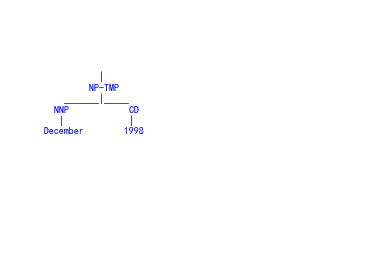

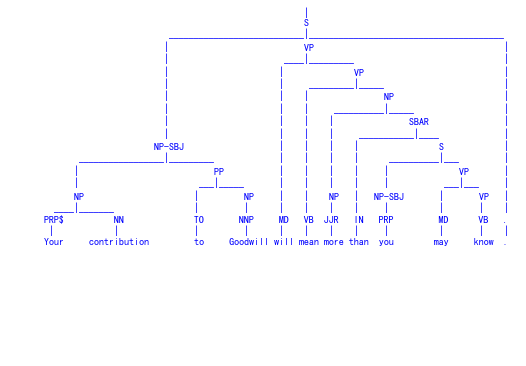

masc test trees:
size355


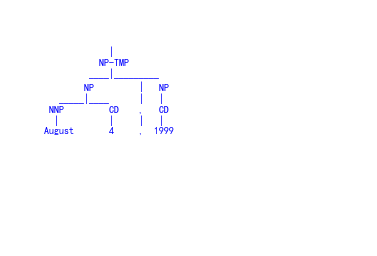

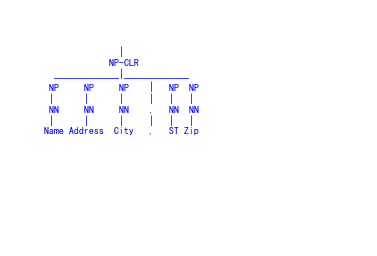

In [55]:
#train_trees = map(Tree.fromstring, sents)
def read_masc_sents(drt):
    import os
    import codecs
    sents = []
    sent = []        
    def get_all_files(drt): # recursive dirs
        files = []
        for filename in os.listdir(drt):
            dir_or_file = os.path.join(drt, filename)
            if os.path.isfile(dir_or_file):
                files.append(dir_or_file)
            else:
                files.extend(get_all_files(dir_or_file))
        return files
        
    cnt = 0
    for filename in get_all_files(drt):
        f = codecs.open(filename, 'rU', 'utf-8')
        #f = open(filename, 'rU')
        for line in f:
            if line == '\n' and len(sent) > 0:
                sent_str = ''.join(sent).strip(' ').strip('\n')              
                if len(sent_str) == 0: continue
                sents.append(sent_str)
                sent = []
            else:
                sent.append(line)
        if len(sent) > 0:
            sents.append(''.join(sent))
            sent = []
    sents = list(filter(lambda x: len(x) > 1, sents))
    return sents

def addRoot(tree):
    tree.set_label('ROOT')
    return tree

masc_train_sents = read_masc_sents('/Users/DY/Desktop/I2NLP/CMP462 HW07 Data/data/parser/masc/train')
masc_train_trees = map(Tree.fromstring, masc_train_sents)
masc_train_trees = list(map(addRoot, masc_train_trees))
masc_train_trees = list(map(Tree.normalize, masc_train_trees))

masc_test_sents = read_masc_sents('/Users/DY/Desktop/I2NLP/CMP462 HW07 Data/data/parser/masc/devtest')
masc_test_trees = map(Tree.fromstring, masc_test_sents)
masc_test_trees = map(addRoot, masc_test_trees)
masc_test_trees = list(map(Tree.normalize, masc_test_trees))

print ('masc train trees:')
print ('size: ' + str(len(masc_train_trees)))
for t in masc_train_sents[:2]:
    draw_tree(t)
print ('masc test trees:')
print ('size' + str(len(masc_test_trees)))
for t in masc_test_sents[:2]:
    draw_tree(t)

+ 下面先定义词法基类，其中有一些复杂的平滑处理。这样做是为了应对未登录词（out of vocabulary, OOV）。

In [6]:
class Lexicon:
    """
    Simple default implementation of a lexicon, which scores word,
    tag pairs with a smoothed estimate of P(word|tag).
    
    """

    def __init__(self, train_trees):
        """
        Builds a lexicon from the observed tags in a list of training
        trees.
        """
        self.total_tokens = 0.0
        self.total_word_types = 0.0
        self.word_to_tag_counters = collections.defaultdict(lambda: collections.defaultdict(float))
        self.tag_counter = collections.defaultdict(float)
        self.word_counter = collections.defaultdict(float)
        self.type_to_tag_counter = collections.defaultdict(float)

        for train_tree in train_trees:
            words = train_tree.get_yield()
            tags = train_tree.get_preterminal_yield()
            for word, tag in zip(words, tags):
                self.tally_tagging(word, tag)

        self.__word_given_tag_prob = collections.defaultdict(float)
        for tag in self.tag_counter:
            for word in self.word_counter:
                self.__word_given_tag_prob[(word, tag)] = self.score_tagging(word, tag)

    def tally_tagging(self, word, tag):
        if not self.is_known(word):
            self.total_word_types += 1
            self.type_to_tag_counter[tag] += 1
        self.total_tokens += 1
        self.tag_counter[tag] += 1
        self.word_counter[word] += 1
        self.word_to_tag_counters[word][tag] += 1

    def get_all_tags(self):
        return self.tag_counter.keys()

    def is_known(self, word):
        return word in self.word_counter

    def score_tagging(self, word, tag):
        word_given_tag = (word, tag)
        if self.__word_given_tag_prob[word_given_tag] != 0:
            return self.__word_given_tag_prob[word_given_tag]


        p_tag = float(self.tag_counter[tag]) / self.total_tokens
        c_word = float(self.word_counter[word])
        c_tag_and_word = float(self.word_to_tag_counters[word][tag])
        if c_word < 10:
            c_word += 1
            c_tag_and_word += float(self.type_to_tag_counter[tag]) / self.total_word_types
        p_word = (1.0 + c_word) / (self.total_tokens + self.total_word_types)
        p_tag_given_word = c_tag_and_word / c_word
        p_word_given_tag = p_tag_given_word / p_tag * p_word
        self.__word_given_tag_prob[word_given_tag] = p_word_given_tag
        return p_word_given_tag

+ 将一般的语法树转化为二叉树，即将一般的上下文无关语法转换为乔姆斯基范式（chomsky norm form, CNF），目的是使下面的解析算法（CYK）的时间复杂度在$O(n^3 * g + n * L)$，其中n为待解析句子的长度，g为语法产生式（production rules）的条数，L为词法规则的条数。

    下面是一种无损的转化形式，即对于(A, B, C)的产生式，$P_C = P(C | A B)$。而Markov order-n smoothing 和 parent annotation可通过调用nltk.Tree的chomsky_normal_form实现。下面是nltk.treetransforms的函数说明：
    ```
    The following is a short tutorial on the available transformations.
    1. Chomsky Normal Form (binarization)

    It is well known that any grammar has a Chomsky Normal Form (CNF)
    equivalent grammar where CNF is defined by every production having
    either two non-terminals or one terminal on its right hand side.
    When we have hierarchically structured data (ie. a treebank), it is
    natural to view this in terms of productions where the root of every
    subtree is the head (left hand side) of the production and all of
    its children are the right hand side constituents.  In order to
    convert a tree into CNF, we simply need to ensure that every subtree
    has either two subtrees as children (binarization), or one leaf node
    (non-terminal).  In order to binarize a subtree with more than two
    children, we must introduce artificial nodes.

    There are two popular methods to convert a tree into CNF: left
    factoring and right factoring.  The following example demonstrates
    the difference between them.  Example::
    
     Original       Right-Factored     Left-Factored

          A              A                      A
        / | \          /   \                  /   \
       B  C  D   ==>  B    A|<C-D>   OR   A|<B-C>  D
                            /  \          /  \
                           C    D        B    C
    2. Parent Annotation

    In addition to binarizing the tree, there are two standard
    modifications to node labels we can do in the same traversal: parent
    annotation and Markov order-N smoothing (or sibling smoothing).

    The purpose of parent annotation is to refine the probabilities of
    productions by adding a small amount of context.  With this simple
    addition, a CYK (inside-outside, dynamic programming chart parse)
    can improve from 74% to 79% accuracy.  A natural generalization from
    parent annotation is to grandparent annotation and beyond.  The
    tradeoff becomes accuracy gain vs. computational complexity.  We
    must also keep in mind data sparcity issues.  Example::

     Original       Parent Annotation

          A                A^<?>
        / | \             /   \
       B  C  D   ==>  B^<A>    A|<C-D>^<?>     where ? is the
                                 /  \          parent of A
                             C^<A>   D^<A>

    3. Markov order-N smoothing

    Markov smoothing combats data sparcity issues as well as decreasing
    computational requirements by limiting the number of children
    included in artificial nodes.  In practice, most people use an order
    2 grammar.  Example::

      Original       No Smoothing       Markov order 1   Markov order 2   etc.

       __A__            A                      A                A
      / /|\ \         /   \                  /   \            /   \
     B C D E F  ==>  B    A|<C-D-E-F>  ==>  B   A|<C>  ==>   B  A|<C-D>
                            /   \               /   \            /   \
                           C    ...            C    ...         C    ...
                      
    4. Unary Collapsing

    Collapse unary productions (ie. subtrees with a single child) into a
    new non-terminal (Tree node).  This is useful when working with
    algorithms that do not allow unary productions, yet you do not wish
    to lose the parent information.  Example::

       A
       |
       B   ==>   A+B
      / \        / \
     C   D      C   D

  Annotation decisions can be thought about in the vertical direction
  (parent, grandparent, etc) and the horizontal direction (number of
  siblings to keep).  Parameters to the following functions specify
  these values.  For more information see:
  Dan Klein and Chris Manning (2003) "Accurate Unlexicalized
  Parsing", ACL-03.  http://www.aclweb.org/anthology/P03-1054
  ```

In [8]:
def losslessly_binarize_tree(tree):
    label = tree.label()
    if tree.is_preterminal():
        return Tree(label, [tree[0]])
    if len(tree) == 1:
        return Tree(label, [losslessly_binarize_tree(tree[0])])

    def binarize_tree_helper(tree, num_children_generated, intermediate_label):
        left_tree = tree[num_children_generated]
        right_tree = None
        children = []
        children.append(losslessly_binarize_tree(left_tree))
        if num_children_generated < len(tree) - 1:
            right_tree = binarize_tree_helper(tree, num_children_generated + 1, intermediate_label + "_" + left_tree.label())
        if right_tree is not None:
            children.append(right_tree)
        return Tree(intermediate_label, children)

    intermediate_label = "@%s->" % label
    #print (intermediate_label)
    
    intermediate_tree = binarize_tree_helper(tree, 0, intermediate_label)
    return Tree(label, intermediate_tree)

def losslessly_unbinarize_tree(annotated_tree):
    """
    Remove intermediate nodes (labels beginning with "@")
    Remove all material on node labels which follow their base
        symbol (cuts at the leftmost -, ^, or : character)
    Examples: a node with label @NP->DT_JJ will be spliced out,
        and a node with label NP^S will be reduced to NP
    """
    def at_filter(string):
        if string.startswith('@'):
            return True
        else:
            return False
    
    def splice_nodes(tree, filter_func):
        root_list = splice_nodes_helper(tree, filter_func)
        if len(root_list) > 1:
            raise Exception("splice_nodes: no unique root after splicing")
        if len(root_list) < 1:
            return None
        return root_list[0]

    def splice_nodes_helper(tree, filter_func):
        spliced_children = []
        if tree.is_preterminal():
            spliced_children = [tree[0]]
        else:
            for child in tree:
                spliced_child_list = splice_nodes_helper(child, filter_func)
                spliced_children.extend(spliced_child_list)
        if filter_func(tree.label()):
            return spliced_children
        return [Tree(tree.label(), spliced_children)]
    
    debinarized_tree = splice_nodes(annotated_tree, at_filter)
    #unannotated_tree = Tree.normalize(debinarized_tree)
    return debinarized_tree

import copy
def h_v_binarize_tree(tree, factor="right", horzMarkov=None, vertMarkov=0, childChar="|", parentChar="^"):
    t = copy.deepcopy(tree)
    nltk.treetransforms.chomsky_normal_form(t, factor, horzMarkov, vertMarkov, childChar, parentChar)
    t = Tree.convert(t)
    return t

def un_h_v_binarize_tree(annoated_tree, expandUnary = True, childChar = "|", parentChar = "^", unaryChar = "+"):
    t = copy.deepcopy(annoated_tree)
    nltk.treetransforms.un_chomsky_normal_form(t, expandUnary, childChar, parentChar, unaryChar)
    #t = Tree.convert(t)
    return t

def collapse_unary(tree, collapsePOS = False, collapseRoot = False, joinChar = "+"):
    t = copy.deepcopy(annoated_tree)
    nltk.treetransforms.collapse_unary(t, collapsePOS, collapseRoot, joinChar)
    t = Tree.convert(t)
    return t

setattr(Tree, 'losslessly_binarize_tree', staticmethod(losslessly_binarize_tree))
setattr(Tree, 'losslessly_unbinarize_tree', staticmethod(losslessly_unbinarize_tree))
setattr(Tree, 'h_v_binarize_tree', staticmethod(h_v_binarize_tree))
setattr(Tree, 'un_h_v_binarize_tree', staticmethod(un_h_v_binarize_tree))
setattr(Tree, 'collapse_unary', staticmethod(collapse_unary))

+ 下面的语法基类仅适用于基于CNF的二叉语法树，其中限定了只能有一元和二元产生式的子类。基类Grammar中有相应的索引结构，可以通过语法产生式的后边索引得到相应的产生式，这可以加速CYK算法的执行。

In [9]:

class Grammar:
    '''
    Simple implementation of a PCFG grammar, offering the ability to
    look up rules by their child symbols.  Rule probability estimates
    are just relative frequency estimates off of training trees.

    self.binary_rules_by_left_child
    self.binary_rules_by_right_child
    self.unary_rules_by_child
    '''
    def __init__(self, train_trees):
        self.unary_rules_by_child = collections.defaultdict(lambda: [])
        self.binary_rules_by_left_child = collections.defaultdict(
                lambda: [])
        self.binary_rules_by_right_child = collections.defaultdict(
                lambda: [])

        unary_rule_counter = collections.defaultdict(lambda: 0)
        binary_rule_counter = collections.defaultdict(lambda: 0)
        symbol_counter = collections.defaultdict(lambda: 0)

        for train_tree in train_trees:
            self.tally_tree(train_tree, symbol_counter,
                    unary_rule_counter, binary_rule_counter)
        for unary_rule in unary_rule_counter:
            unary_prob = float(unary_rule_counter[unary_rule]) / symbol_counter[unary_rule.parent]
            unary_rule.score = unary_prob
            self.add_unary(unary_rule)
        for binary_rule in binary_rule_counter:
            binary_prob = float(binary_rule_counter[binary_rule]) / symbol_counter[binary_rule.parent]
            binary_rule.score = binary_prob
            self.add_binary(binary_rule)

    def __str__(self):
        rule_strings = []
        for left_child in self.binary_rules_by_left_child:
            for binary_rule in self.get_binary_rules_by_left_child(left_child):
                rule_strings.append(str(binary_rule))
        for child in self.unary_rules_by_child:
            for unary_rule in self.get_unary_rules_by_child(child):
                rule_strings.append(str(unary_rule))
        return "%s\n" % "".join(rule_strings)

    def add_binary(self, binary_rule):
        self.binary_rules_by_left_child[binary_rule.left_child].append(binary_rule)
        self.binary_rules_by_right_child[binary_rule.right_child].append(binary_rule)

    def add_unary(self, unary_rule):
        self.unary_rules_by_child[unary_rule.child].append(unary_rule)

    def get_binary_rules_by_left_child(self, left_child):
        return self.binary_rules_by_left_child[left_child]

    def get_binary_rules_by_right_child(self, right_child):
        return self.binary_rules_by_right_child[right_child]

    def get_unary_rules_by_child(self, child):
        return self.unary_rules_by_child[child]

    def make_unary_rule(self, tree):
        return UnaryRule(tree.label(), tree[0].label())

    def make_binary_rule(self, tree):
        return BinaryRule(tree.label(), tree[0].label(),
                tree[1].label())
    
    def tally_tree(self, tree, symbol_counter, unary_rule_counter, binary_rule_counter):
        if tree.is_preterminal():
            return
        if len(tree) == 1:
            unary_rule = self.make_unary_rule(tree)
            symbol_counter[tree.label()] += 1
            unary_rule_counter[unary_rule] += 1
        if len(tree) == 2:
            binary_rule = self.make_binary_rule(tree)
            symbol_counter[tree.label()] += 1
            binary_rule_counter[binary_rule] += 1
        if len(tree) < 1 or len(tree) > 2:
            raise Exception("Attempted to construct a Grammar with " + "an illegal tree (most likely not binarized): "                     + str(tree))
        for child in tree:
            self.tally_tree(child, symbol_counter, unary_rule_counter,
                    binary_rule_counter)

class BinaryRule:
    """
    A binary grammar rule with score representing its probability.
    """
    def __init__(self, parent, left_child, right_child):
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        self.score = 0.0

    def __str__(self):
        return "%s->%s %s %% %s" % (self.parent, self.left_child, self.right_child, self.score)

    def __hash__(self):
        result = hash(self.parent)
        result = 29 * result + hash(self.left_child)
        result = 29 * result + hash(self.right_child)
        return result

    def __eq__(self, o):
        if self is o:
            return True
        if not isinstance(o, BinaryRule):
            return False
        if (self.left_child != o.left_child):
            return False
        if (self.right_child != o.right_child):
            return False
        if (self.parent != o.parent):
            return False
        return True

class UnaryRule:
    '''
    A unary grammar rule with score representing its probability.
    '''
    def __init__(self, parent, child):
        self.parent = parent
        self.child = child
        self.score = 0.0

    def __str__(self):
        return "%s->%s %% %s" % (self.parent, self.child, self.score)

    def __hash__(self):
        result = hash(self.parent)
        result = 29 * result + hash(self.child)
        return result

    def __eq__(self, o):
        if self is o:
            return True
        if not isinstance(o, UnaryRule):
            return False
        if (self.child != o.child):
            return False
        if (self.parent != o.parent):
            return False
        return True

+ 解析器的基类和一种基于CYK算法（the Cocke–Younger–Kasami algorithm, which employs bottom-up parsing and dynamic programming.）的PCFG语法解析器。


In [10]:
class Parser:
    '''
    A base class of Parser
    '''
    def train(self, train_trees):
        pass

    def get_best_parse(self, sentence):
        """
        Should return a Tree
        """
        pass

In [11]:
class CYKParser(Parser):
    '''
    一种基于CYK算法的PCFG语法解析器
    '''
    def __init__(self, binarize=Tree.losslessly_binarize_tree, unbinarize=Tree.losslessly_unbinarize_tree):
        self.binarize = binarize
        self.unbinarize = unbinarize
    
    def train(self, train_trees):
        '''
        Note: before you generate your grammar, the training
        trees need to be binarized so that rules are at most binary 
        '''
        
        binarized_train_trees = list(map(self.binarize, train_trees))
        self.lexicon = Lexicon(binarized_train_trees)
        self.grammar = Grammar(binarized_train_trees)

    def get_best_parse(self, sentence, root='ROOT', print_matrix=False):
        '''
        Should return a Tree, None if not exist.
        'sentence' is a list of strings (words) that form a sentence.
        '''
        n_sent = len(sentence)
        score = [[collections.defaultdict(float) for _ in range(n_sent + 1)] for _ in range(n_sent + 1)]
        back = [[collections.defaultdict(lambda: ()) for _ in range(n_sent + 1)] for _ in range(n_sent + 1)]

        # lexicon
        tags = self.lexicon.get_all_tags()
        span = 1
        for start in range(n_sent):
            word = sentence[start]
            end = start + span
            for tag in tags:
                score[start][end][tag] = self.lexicon.score_tagging(word, tag)
                back[start][end][tag] = (word, 'word') # in case of rule: , -> , , which will case recursion-loop

            # unary rule: A -> B
            upd = True
            while upd:
                upd = False
                B_set = set(score[start][end].keys())
                for B in B_set: # when using score[start][end]: RuntimeError: dictionary changed size during iteration
                    for unary in self.grammar.get_unary_rules_by_child(B):
                        A = unary.parent
                        A_score = score[start][end][B] * unary.score
                        if A_score > score[start][end][A]:
                            score[start][end][A] = A_score
                            back[start][end][A] = (B,)
                            upd = True

        # binary rule: A -> B C
        for span in range(2, n_sent + 1):
            for start in range(n_sent):
                end = start + span
                if end > n_sent: continue
                for split in range(start + 1, end):
                    for B in score[start][split]:
                        for binary in self.grammar.get_binary_rules_by_left_child(B):
                            C = binary.right_child
                            if score[split][end][C] == 0: continue
                            A = binary.parent
                            A_score = score[start][split][B] * score[split][end][C] * binary.score
                            if A_score > score[start][end][A]:
                                score[start][end][A] = A_score
                                back[start][end][A] = (split, B, C)
                # unary rule: A -> B
                upd = True
                while upd:
                    upd = False
                    B_set = set(score[start][end].keys())
                    for B in B_set:
                        for unary in self.grammar.get_unary_rules_by_child(B):
                            A = unary.parent
                            A_score = score[start][end][B] * unary.score
                            if A_score > score[start][end][A]:
                                score[start][end][A] = A_score
                                back[start][end][A] = (B,)
                                upd = True
        
        #debug
        if print_matrix:
            print ('=' * 100)
            print ('back matrix:')
            for span in range(n_sent, 0, -1):
                for start in range(n_sent):
                    end = start + span
                    if end > n_sent: continue
                    #print (str(score[start][end].items()) + '\t',)
                    sys.stdout.write(str(len(score[start][end])) + '\t')
                sys.stdout.write('\n')
            print ('=' * 100)

        # construct tree
        #if not score[0][n_sent][root] == 0: #todo
        #   return None
        
        def construct_tree(A, start, end):
            head = back[start][end][A]
            #children = []
            if len(head) == 0:
                children = []
            elif len(head) == 1: #unary rule
                children = [construct_tree(head[0], start, end)]
            elif len(head) == 2: #preterminal
                children = [head[0]]
            else: #binary rule
                split, B, C = back[start][end][A]
                l_child = construct_tree(B, start, split)
                r_child = construct_tree(C, split, end)
                children = [l_child, r_child]

            return Tree(A, children)

        best_tree = construct_tree(root, 0, n_sent)
        #print ('best_tree construct:')
        #print (best_tree)
        #best_tree.set_words(sentence)
        #print ('best_tree set_words:')
        #print (best_tree)
        best_tree = self.unbinarize(best_tree)
        #print ('best_tree unbinarize:')
        #print (best_tree)
        return best_tree

In [57]:
#binarize = Tree.losslessly_binarize_tree
#unbinarize = Tree.losslessly_unbinarize_tree

binarize = ft.partial(Tree.h_v_binarize_tree, factor="right", horzMarkov=2, vertMarkov=2, childChar="|", parentChar="^")
unbinarize = ft.partial(Tree.un_h_v_binarize_tree, expandUnary = True, childChar = "|", parentChar = "^", unaryChar = "+")

cyk_parser = CYKParser(binarize, unbinarize)
cyk_parser.train(masc_train_trees)

+ 评估

    Evaluates precision and recall for Penn Treebank parse
    trees.  NOTE: Unlike the standard evaluation, multiplicity over
    each span is ignored.  Also, punctuation is NOT currently deleted
    properly (approximate hack), and other normalizations (like AVDP ~
    PRT) are NOT done.
    
    由于tag-word rule的成功率比较高，所以在评估的时候不考虑她。

In [62]:
class AbstractEval:
    def __init__(self):
        self.string = ""
        self.exact = 0
        self.total = 0
        self.correct_events = 0
        self.guessed_events = 0
        self.gold_events = 0

    def evaluate(self, guess, gold):
        """
        Evaluates precision and recall by calling makeObjects() to make a
        set of structures for guess Tree and gold Tree, and compares them
        with each other.
        """
        guessed_set = self.make_objects(guess)
        gold_set = self.make_objects(gold)
        correct_set = set()
        correct_set.update(gold_set)
        correct_set.intersection_update(guessed_set)

        self.correct_events += len(correct_set)
        self.guessed_events += len(guessed_set)
        self.gold_events += len(gold_set)

        current_exact = 0
        if len(correct_set) == len(guessed_set) and len(correct_set) == len(gold_set):
            self.exact += 1
            current_exact = 1
        self.total += 1

        return self.display_prf(self.string + " [Current] ", len(correct_set),
                len(guessed_set), len(gold_set), current_exact, 1)

    def display_prf(self, pre_str, correct, guessed, gold, exact, total):

        precision = correct / float(guessed) if guessed > 0 else 1.0
        recall = correct / float(gold) if gold > 0 else 1.0
        f1 = 2.0 / (1.0 / precision + 1.0 / recall) if precision > 0.0 and recall > 0.0 else 0.0
        exact_match = exact / float(total)

        print ("%s   P: %5.2f   R: %5.2f   F1: %5.2f   EX: %5.2f" % (pre_str, 100.0 * precision, 100.0 * recall, 100.0 * f1, 100.0 * exact_match))
        return 100.0 * f1

    def display(self, verbose):
        return self.display_prf(self.string + " [Average] ", self.correct_events, self.guessed_events, self.gold_events, self.exact, self.total)

class LabeledConstituent:
    def __init__(self, label, start, end):
        self.label = label
        self.start = start
        self.end = end

    def __eq__(self, o):
        if self is o:     # tests if they are the same exact object
            return True
        if not isinstance(o, LabeledConstituent):
            return False
        if self.end != o.end or self.start != o.start or \
                self.label != o.label:
            return False
        return True

    def __hash__(self):
        # For comparison (with sets)
        result = hash(self.label)
        result = 29 * result + self.start
        result = 29 * result + self.end
        return result

    def __unicode__(self):
        return "%s[%d,%d]" % (self.label, self.start, self.end)

    def __str__(self):
        return unicode(self).encode('utf-8')

class LabeledConstituentEval(AbstractEval):
    def __init__(self, labels_to_ignore, punctuation_tags):
        #AbstractEval.__init__(self)
        super().__init__()
        #super(LabeledConstituentEval, self).__init__()
        self.labels_to_ignore = set(labels_to_ignore)
        self.punctuation_tags = set(punctuation_tags)

    def make_objects(self, tree):
        #no_leaf_tree = self.strip_leaves(tree)
        aset = set()
        self.add_constituents(tree, aset, 0)
        return aset
    
    #without tag-word rule
    def add_constituents(self, tree, aset, start): 
        label = tree.label()
        if tree.is_preterminal():
            if tree.label() in self.punctuation_tags:
                return 0
            else:
                return 1
        end = start
        for child in tree:
            child_span = self.add_constituents(child, aset, end)
            end += child_span
        label = tree.label()
        if label not in self.labels_to_ignore:
            aset.add(LabeledConstituent(label, start, end))
        return end - start

@timeit
def test_parser(parser, test_trees):
    evaluator = LabeledConstituentEval(
            ["ROOT"], set(["''", "``", ".", ":", ","]))
    cnt = 0
    for test_tree in test_trees:
        cnt += 1
        test_sentence = test_tree.get_yield()
        if len(test_sentence) > 20:
            continue
        guessed_tree = parser.get_best_parse(test_sentence, print_matrix=False)
        #print ("Guess:")
        #print (guessed_tree)
        #draw_tree(str(guessed_tree))
        #print ("Gold:")
        #draw_tree(str(test_tree))
        evaluator.evaluate(guessed_tree, test_tree)
    print ()

    return evaluator.display(True)

test_parser(cyk_parser, masc_test_trees)

call test_parser(args=(<__main__.CYKParser object at 0x2834174a8>, [Tree('ROOT', [Tree('NP', [Tree('NP', [Tree('NNP', ['Au, kw={}):
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 75.00   R: 50.00   F1: 60.00   EX:  0.00
 [Current]    P: 66.67   R: 72.73   F1: 69.57   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 50.00   R: 42.86   F1: 46.15   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 75.00   R: 50.00   F1: 60.00   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 85.71   R: 85.71   F1: 85.71   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 75.00   R: 50.00   F1: 60.00   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 77.78   R: 70.00   F1: 73.68   EX:  0.00
 [Current]    P: 23.08   R: 

76.5217391304348

+ 定义一个调试函数，她可以打印出带生成概率的语法树，并提供和基准树的对比。

In [14]:
def debug_trees(train_trees, guess_trees, gold_trees):
    '''
        Print tree strings with probs, in terms of 'label:prob' in every tree node.
    '''
    rules = collections.defaultdict(float)
    A_counter = collections.defaultdict(float)
    lexicon = Lexicon(train_trees)

    def tally_tree(self, tree, A_counter):
        if tree.is_preterminal():
            return
        A = tree.label()
        rule = tuple([A] + map(op.attrgetter('label'), tree))
        A_counter[A] += 1
        rules[rule] += 1
        for child in tree:
            tally_tree(child, A_counter)

    for train_tree in train_trees:
        tally_tree(train_tree, A_counter)

    for rule in rules:
        prob = float(rules[rule]) / A_counter[rule[0]]
        rules[rule] = prob

    def construct_tree_with_prob(root):
        if root.is_leaf():
            return root, 1.

        if root.is_preterminal():
            A = root.label()
            B = root[0].label()
            prob = lexicon.score_tagging((B, A))
            return Tree(A + ':' + str(prob), root), prob

        rule = tuple([root.label()] + map(op.attrgetter('label'), root.children))
        children = []
        prob = rules[rule]
        for child in root.children:
            child_tree, child_prob = construct_tree_with_prob(child)
            prob *= child_prob
            children.append(child_tree)
        return Tree(rule[0] + ':' + str(prob), children), prob

    guess_trees_with_prob = []
    gold_trees_with_prob = []
    for guess_tree in guess_trees:
        best_tree_with_prob = construct_tree_with_prob(guess_tree)[0]
        guess_trees_with_prob.append(best_tree_with_prob)

    for gold_tree in gold_trees:
        gold_tree_with_prob = construct_tree_with_prob(gold_tree)[0]
        gold_trees_with_prob.append(gold_tree_with_prob)

    return guess_trees_with_prob, gold_trees_with_prob

2. 处理中文语料。

    Chinese Treebank(chtb) 8.0, Linguistic Data Consortium (LDC) Catalog Number LDC2013T21 and ISBN 1-58563-661-4, consists of approximately 1.5 million words of annotated and parsed text from Chinese newswire, government documents, magazine articles, various broadcast news and broadcast conversation programs, web newsgroups and weblogs.
    
    The Chinese Treebank project began at the University of Pennsylvania in 1998, continued at the University of Colorado and then moved to Brandeis University. The project's goal is to provide a large, part-of-speech tagged and fully bracketed Chinese language corpus. The first delivery, Chinese Treebank 1.0, contained 100,000 syntactically annotated words from Xinhua News Agency newswire. It was later corrected and released in 2001 as Chinese Treebank 2.0 (LDC2001T11) and consisted of approximately 100,000 words. The LDC released Chinese Treebank 4.0 (LDC2004T05), an updated version containing roughly 400,000 words, in 2004. A year later, LDC published the 500,000 word Chinese Treebank 5.0 (LDC2005T01). Chinese Treebank 6.0 (LDC2007T36), released in 2007, consisted of 780,000 words. Chinese Treebank 7.0 (LDC2010T08), released in 2010, added new annotated newswire data, broadcast material and web text to the approximate total of one million words. Chinese Treebank 8.0 adds new annotated data from newswire, magazine articles and government documents.
    
    chtb中含有18804条句子。

In [37]:
def read_chtb_sents(dir_or_file_or_str):
    from html.parser import HTMLParser
    from html.entities import name2codepoint

    class MyHTMLParser(HTMLParser):
        def __init__(self):
            HTMLParser.__init__(self)
            self.__tags = ('s')
            self.__trigged = 0 # recursive: <S>...<S>...</S>...</S>
            self.sent = []
            self.sents = []
    
        def handle_starttag(self, tag, attrs):
            if tag in self.__tags:
                self.__trigged += 1
            #print('starttag:<%s>' % tag)

        def handle_endtag(self, tag):
            if tag in self.__tags:
                self.__trigged -= 1
                if self.__trigged == 0:
                    sent_str = ''.join(self.sent)
                    #print (sent_str)
                    # split single sent
                    st_n = 0
                    start = 0
                    for i, c in enumerate(sent_str):
                        if c == '(':
                            st_n += 1
                        elif c == ')':
                            st_n -= 1
                            if st_n == 0:
                                self.sents.append(sent_str[start:i + 1])
                                start = i + 1
                    self.sent = []
            #print('endtag:</%s>' % tag)

        def handle_startendtag(self, tag, attrs):
            #print('startendtag:<%s/>' % tag)
            pass

        def handle_data(self, data):
            if self.__trigged > 0:
                self.sent.append(data)
            #print('data:' + data)

        def handle_comment(self, data):
            #print('comment:<!--', data, '-->')
            pass

        def handle_entityref(self, name):
            #print('endtityref:&%s;' % name)
            pass

        def handle_charref(self, name):
            #print('charref:&#%s;' % name)
            pass
    
    import os
    import codecs
    parser = MyHTMLParser()
    if os.path.isdir(dir_or_file_or_str):
        def get_all_files(dir): # recursive dirs
            files = []
            for filename in os.listdir(dir):
                dir_or_file = os.path.join(dir, filename)
                if os.path.isfile(dir_or_file):
                    files.append(dir_or_file)
                else:
                    files.extend(get_all_files(dir_or_file))
            return files
        
        for filename in get_all_files(dir_or_file_or_str):
            f = codecs.open(filename, 'rU', 'utf-8')
            for line in f:
                parser.feed(line)
    
    elif os.path.isfile(dir_or_file_or_str):
        f = codecs.open(dir_or_file_or_str, 'rU', 'utf-8')
        for line in f:
            parser.feed(line)
    else:
        parser.feed(dir_or_file_or_str)
    return parser.sents

dir_or_file_or_str = '/Users/DY/Downloads/ctb8.0/data/bracketed'
chtb_sents = read_chtb_sents(dir_or_file_or_str)
print (len(chtb_sents))

18804


chtb train trees:


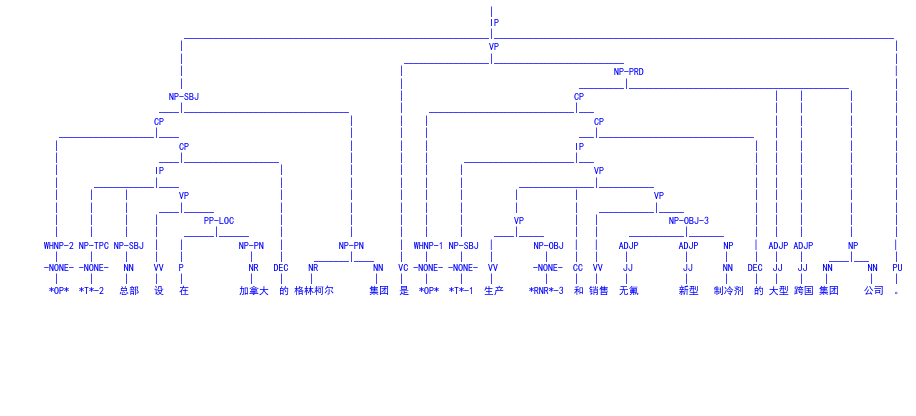

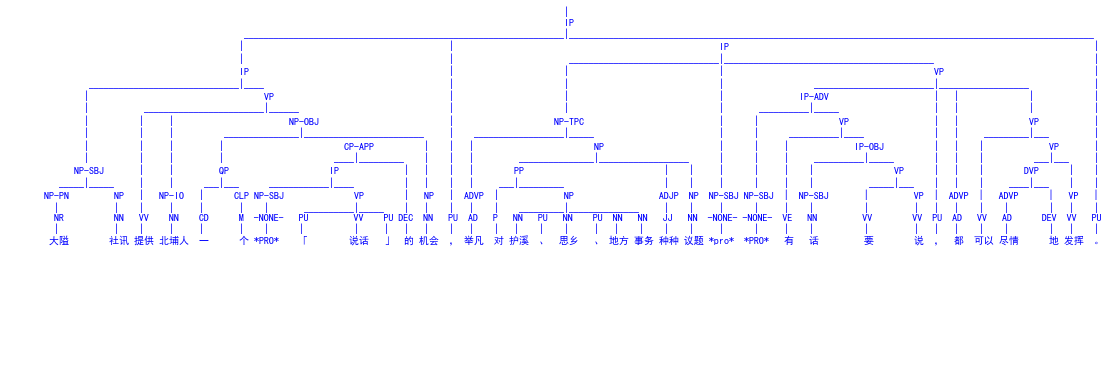

chtb test trees:


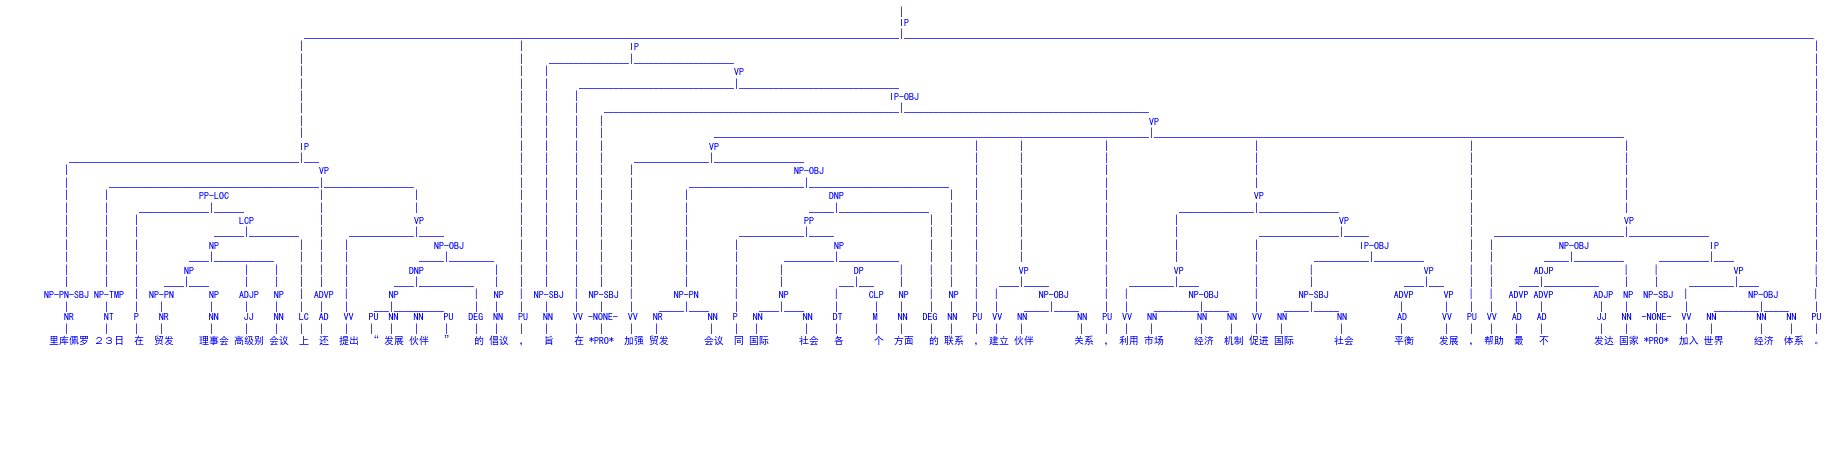

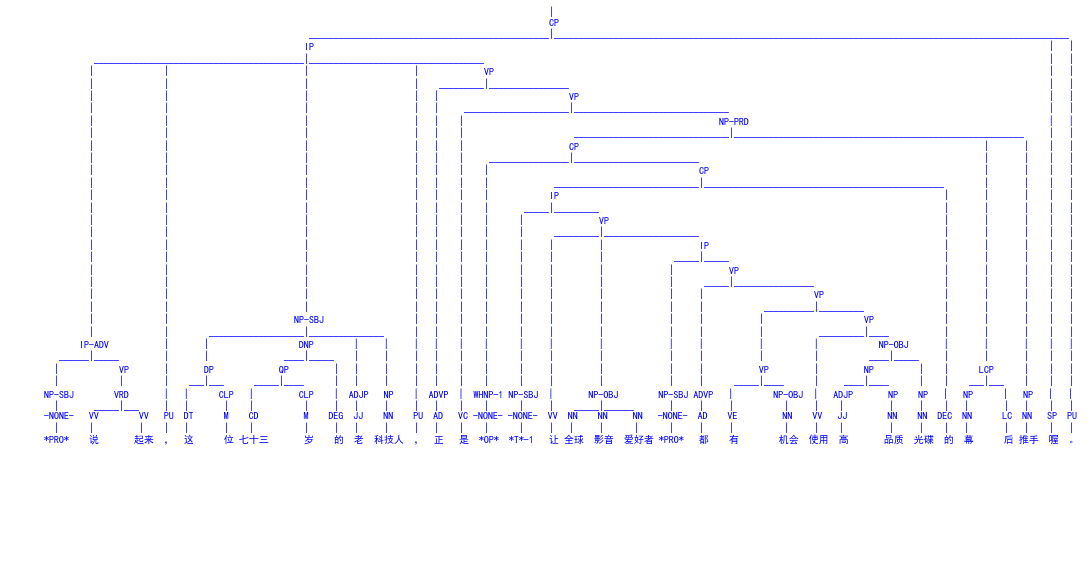

In [39]:
import random
random.shuffle(chtb_sents)
n = len(chtb_sents)
chtb_train_sents = chtb_sents[:int(n * 0.9)]
chtb_test_sents = chtb_sents[int(n * 0.9):]
print ('chtb train trees:')
for t in chtb_train_sents[:2]:
    draw_tree(t)
print ('chtb test trees:')
for t in chtb_test_sents[:2]:
    draw_tree(t)
    
chtb_train_trees = map(Tree.fromstring, chtb_train_sents)
chtb_train_trees = list(map(addRoot, chtb_train_trees))
chtb_train_trees = list(map(Tree.normalize, chtb_train_trees))

chtb_test_trees = map(Tree.fromstring, chtb_test_sents)
chtb_test_trees = list(map(addRoot, chtb_test_trees))
chtb_test_trees = list(map(Tree.normalize, chtb_test_trees))

In [33]:
#binarize = Tree.losslessly_binarize_tree
#unbinarize = Tree.losslessly_unbinarize_tree

binarize = ft.partial(Tree.h_v_binarize_tree, factor="right", horzMarkov=2, vertMarkov=2, childChar="|", parentChar="^")
unbinarize = ft.partial(Tree.un_h_v_binarize_tree, expandUnary = True, childChar = "|", parentChar = "^", unaryChar = "+")

cyk_parser = CYKParser(binarize, unbinarize)
cyk_parser.train(chtb_train_trees)

+ 评测，利用（tag，start，end）集合的方式表达学习的解析树。

In [34]:
test_parser(cyk_parser, chtb_test_trees)

 [Current]    P: 90.00   R: 69.23   F1: 78.26   EX:  0.00
 [Current]    P: 88.89   R: 72.73   F1: 80.00   EX:  0.00
 [Current]    P: 50.00   R: 35.71   F1: 41.67   EX:  0.00
 [Current]    P: 83.33   R: 88.24   F1: 85.71   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 60.00   R: 37.50   F1: 46.15   EX:  0.00
 [Current]    P: 75.00   R: 60.00   F1: 66.67   EX:  0.00
 [Current]    P: 100.00   R: 33.33   F1: 50.00   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 64.71   R: 57.89   F1: 61.11   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 78.95   R: 65.22   F1: 71.43   EX:  0.00
 [Current]    P: 25.00   R: 100.00   F1: 40.00   EX:  0.00
 [Current]    P:  0.00   R:  0.00   F1:  0.00   EX:  0.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00   EX: 100.00
 [Current]    P: 100.00   R: 100.00   F1: 100.00  

74.11901697615984

可以看出F1值为74%以上。